In [7]:
import torch
import numpy as np
from torch import nn
import time
from FrEIA.framework import InputNode, OutputNode, Node, GraphINN, ConditionNode
from FrEIA.modules import GLOWCouplingBlock
import FrEIA.modules as Fm

torch.set_default_dtype(torch.float64)
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

DIMENSION = 3
ndim_y = 23 

# load forward model
forward_model = nn.Sequential(nn.Linear(DIMENSION, 256), nn.ReLU(),
                              nn.Linear(256, 256), nn.ReLU(),
                              nn.Linear(256, 256), nn.ReLU(),
                              nn.Linear(256,  ndim_y)).to(device)

forward_model.load_state_dict(torch.load('forward_model_new.pt'))
for param in forward_model.parameters():
    param.requires_grad=False

    
    
# define parameters
x_total_per_y = 2000
relu = torch.nn.ReLU()


In [8]:
# log posterior function for error model
def get_log_posterior(samples, forward_model, a, b, ys,lambd_bd=10):
    relu=torch.nn.ReLU()
    forward_samps=forward_model(samples)
    prefactor = ((b*forward_samps)**2+a**2)
    p = .5*torch.sum(torch.log(prefactor), dim = 1)
    p2 =  0.5*torch.sum((ys-forward_samps)**2/prefactor, dim = 1)
    p3 = lambd_bd*torch.sum(relu(samples-1)+relu(-samples-1), dim = 1)
    return p+p2+p3

# normalizing flow architecture
def create_INN(num_layers, sub_net_size):
    def subnet_fc(c_in, c_out):
        return nn.Sequential(nn.Linear(c_in, sub_net_size), nn.ReLU(),
                             nn.Linear(sub_net_size, sub_net_size), nn.ReLU(),
                             nn.Linear(sub_net_size,  c_out))

    nodes = [InputNode(DIMENSION, name='input')]
    cond = ConditionNode(ndim_y, name='condition')
    for k in range(num_layers):
        nodes.append(Node(nodes[-1],
                          GLOWCouplingBlock,
                          {'subnet_constructor':subnet_fc, 'clamp':1.4},
                          conditions = cond,
                          name=F'coupling_{k}'))
    nodes.append(OutputNode(nodes[-1], name='output'))
    model = GraphINN(nodes + [cond], verbose=False).to(device)
    return model

# em algo
def em_ab(a_sq_init,b_sq_init,f_x,y,steps=20):
    def compute_c1_c2(a_sq_r,b_sq_r,f_x_inp,y_inp):
        l2_dist=(y_inp-f_x_inp)**2
        c_nenner=a_sq_r+b_sq_r*f_x_inp**2
        c_nenner_sq=c_nenner**2
        v_variance=a_sq_r*b_sq_r*f_x_inp**2/c_nenner

        c1_=-(l2_dist*(1-2*a_sq_r/c_nenner+a_sq_r**2/c_nenner_sq)+v_variance)/(f_x_inp**2)
        c2_=-(l2_dist*a_sq_r**2/c_nenner_sq+v_variance)
        c1=torch.sum(c1_/y.shape[1])
        c2=torch.sum(c2_/y.shape[1])
        return c1,c2
    a_sq = a_sq_init
    b_sq = b_sq_init
    for step in range(steps):
        c1,c2=compute_c1_c2(a_sq,b_sq,f_x,y)
        a_sq_new=-c2/(y.shape[0])
        b_sq_new=-c1/(y.shape[0])
        a_sq=a_sq_new
        b_sq=b_sq_new
    return a_sq,b_sq
    
# forward KL training
def train_inn_epoch(model,optimizer, a, b, forward_model, batch_size = 512):
    for k in range(10):
        x = torch.rand(batch_size, DIMENSION, device = device)*2-1
        ys = forward_model(x) + b*forward_model(x)*torch.randn(batch_size, ndim_y, device = device)+a*torch.randn(batch_size, ndim_y, device = device)
        optimizer.zero_grad()
        out = model(x, c = ys, rev = True)
        output = out[0].to(device)
        jac = out[1].to(device)
        l = 0.5*torch.sum(output**2)/batch_size
        l = l - torch.mean(jac)
        l.backward()
        optimizer.step()
    for k in range(1):
        ys = torch.zeros(len(meas), ndim_y, device = device)
        ys += meas.to(device)
        ys = ys.repeat(x_total_per_y//len(meas),1)
        z = torch.randn(len(ys), DIMENSION, device = device)
        out = model(z, c = ys)
        output = out[0].to(device)
        fx = forward_model(output)
        a,b = em_ab(a**2,b**2,fx,ys)
        a = torch.sqrt(a.abs())
        b = torch.sqrt(b.abs())
    return l,a,b

# calculation of elbo
def calc_elbo(a,b,model, meas):
    with torch.no_grad():
        ys = torch.zeros(len(meas), ndim_y, device = device)
        ys += meas.to(device)
        ys = ys.repeat(2000//len(meas),1)
        z = torch.randn(len(ys), DIMENSION, device = device)
        out,jac = model(z, c = ys)
        elbo = -get_log_posterior(out, forward_model, a,b, ys).mean() + jac.mean()
    return elbo
    


def savePost(posterior, no_params, x_true,l):
    fig, axes = plt.subplots(figsize=[9,9], nrows=no_params, ncols=no_params);
    posterior = posterior[0].cpu().data.numpy()
    x_true = x_true.cpu().data.numpy().reshape(1,DIMENSION)
    for j in range(no_params):
        for k in range(no_params):
            axes[j,k].get_xaxis().set_ticks([]);
            axes[j,k].get_yaxis().set_ticks([]);
            if k == 0: axes[j,k].set_ylabel(j);
            #if j == len(params)-1: axes[j,k].set_xlabel(k);
            if j == k:
                axes[k,k].hist(posterior[:,j], bins=50,  alpha=0.3,range = (-1.2,1.2));
                axes[k,k].hist(posterior[:,j], bins=50,  histtype="step", range = (-1.2,1.2));
                axes[k,k].axvline(x_true[:,j])
            else:
                val, x, y = np.histogram2d(posterior[:,j], posterior[:,k], bins=25, range = [[-1.2, 1.2], [-1.2, 1.2]]);
                axes[j,k].contourf(val, 8, extent=[x[0], x[-1], y[0], y[-1]], alpha=1);
    plt.tight_layout()
    plt.savefig('posterior_forw' +str(l)+'.png')

0
tensor(74.4343, device='cuda:0')
tensor(0.0071, device='cuda:0', grad_fn=<SqrtBackward0>) tensor(0.1120, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(78.9449, device='cuda:0')
tensor(0.0043, device='cuda:0', grad_fn=<SqrtBackward0>) tensor(0.1219, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(76.7440, device='cuda:0')
tensor(0.0019, device='cuda:0', grad_fn=<SqrtBackward0>) tensor(0.1580, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(77.2984, device='cuda:0')
tensor(0.0057, device='cuda:0', grad_fn=<SqrtBackward0>) tensor(0.1120, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(84.2052, device='cuda:0')
tensor(0.0072, device='cuda:0', grad_fn=<SqrtBackward0>) tensor(0.0426, device='cuda:0', grad_fn=<SqrtBackward0>)
1
tensor(79.1054, device='cuda:0')
tensor(0.0067, device='cuda:0', grad_fn=<SqrtBackward0>) tensor(0.0806, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(76.9956, device='cuda:0')
tensor(0.0062, device='cuda:0', grad_fn=<SqrtBackward0>) tensor(0.1076, device='c

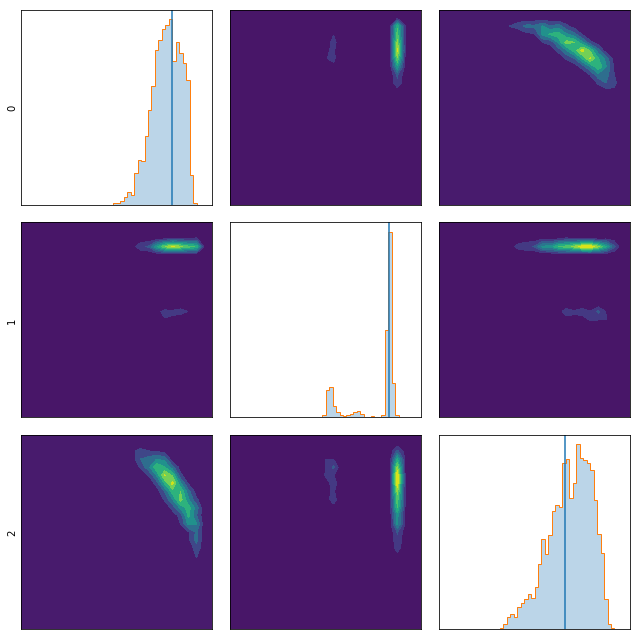

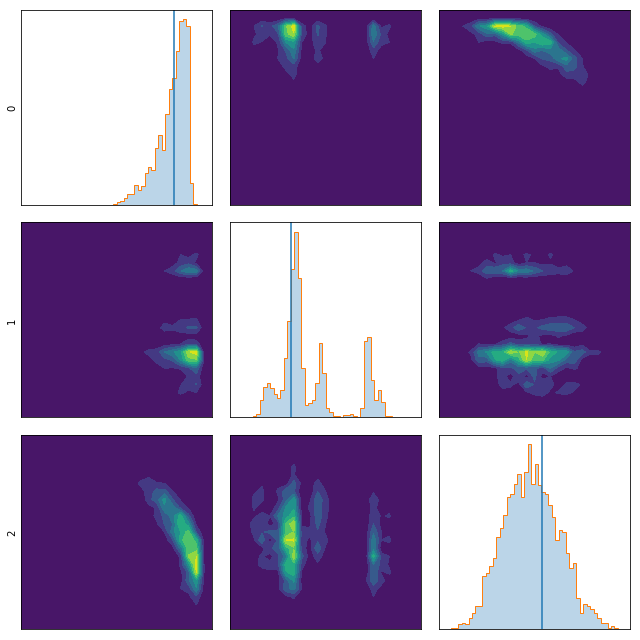

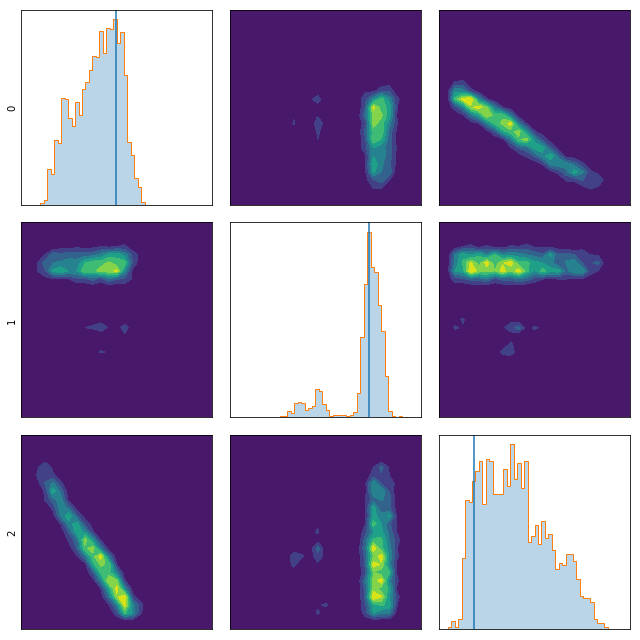

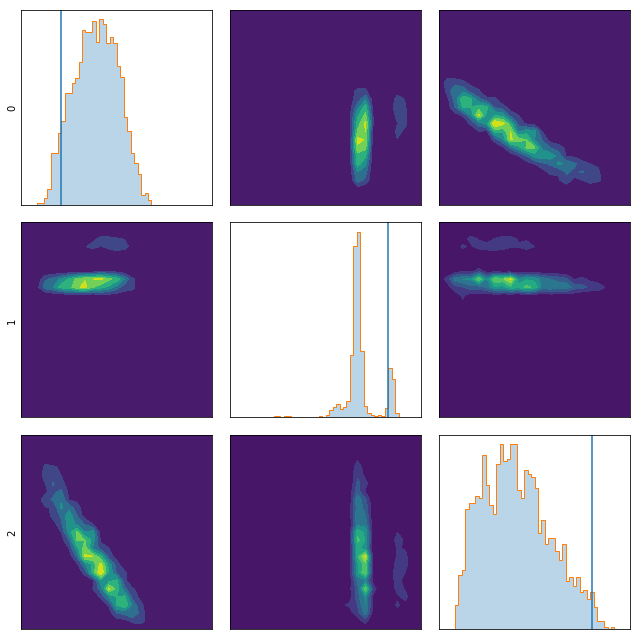

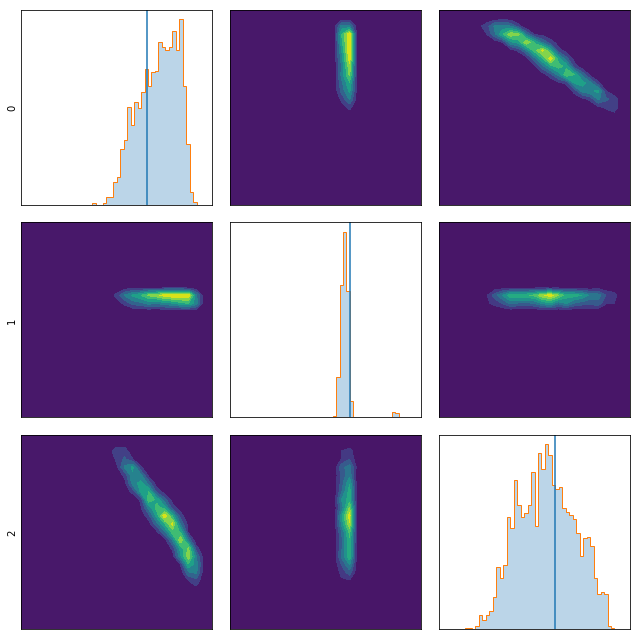

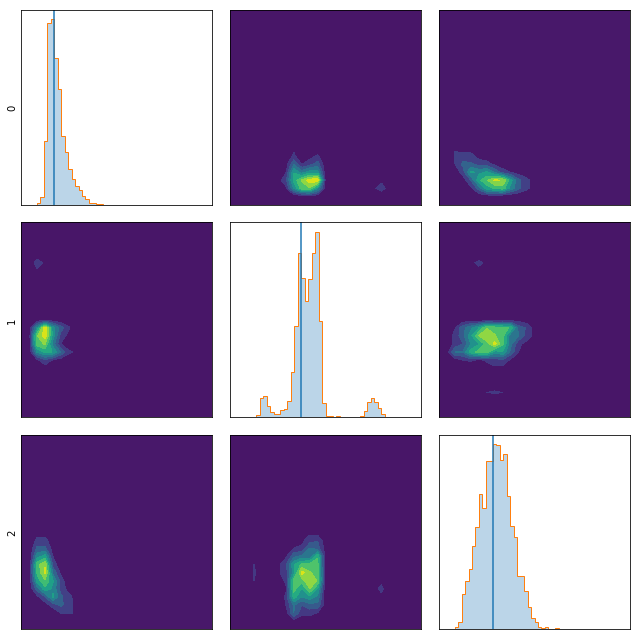

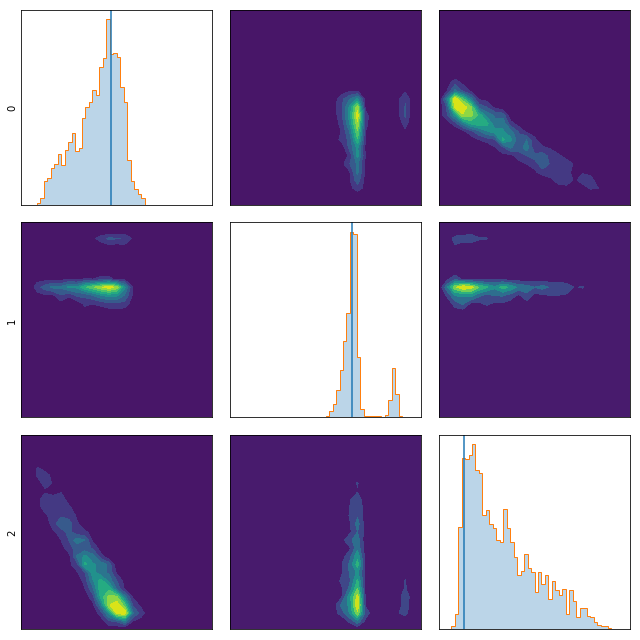

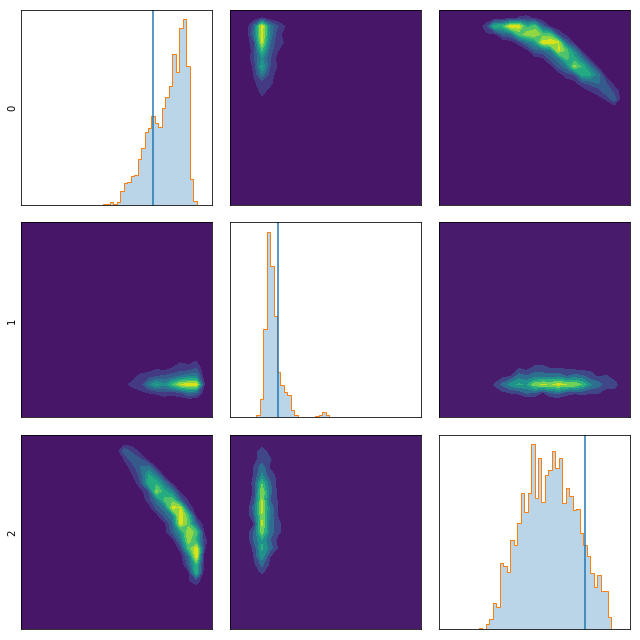

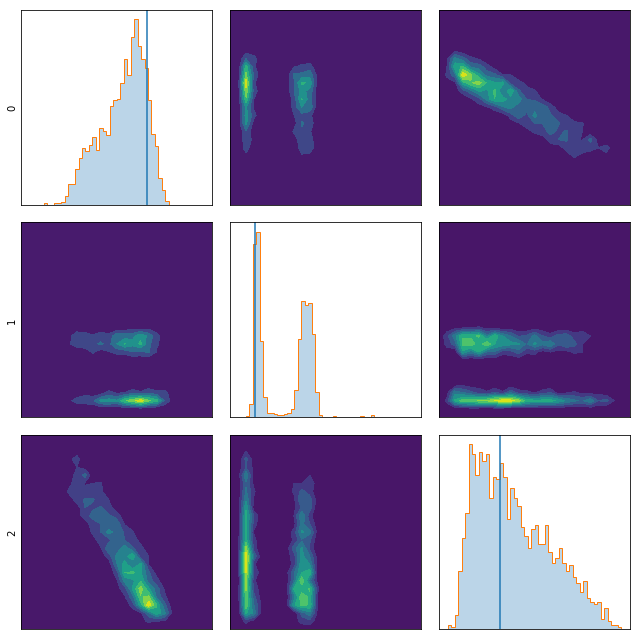

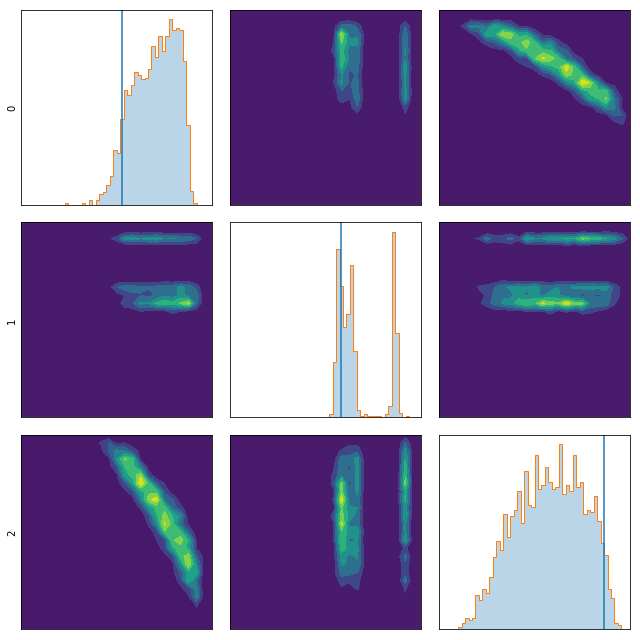

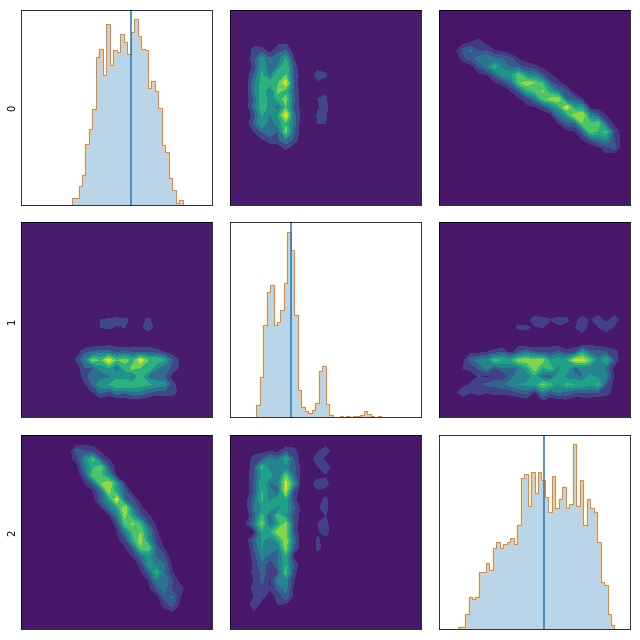

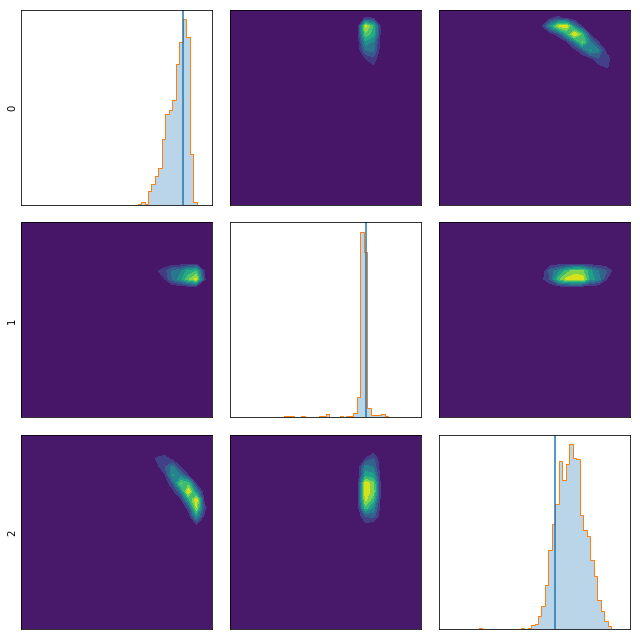

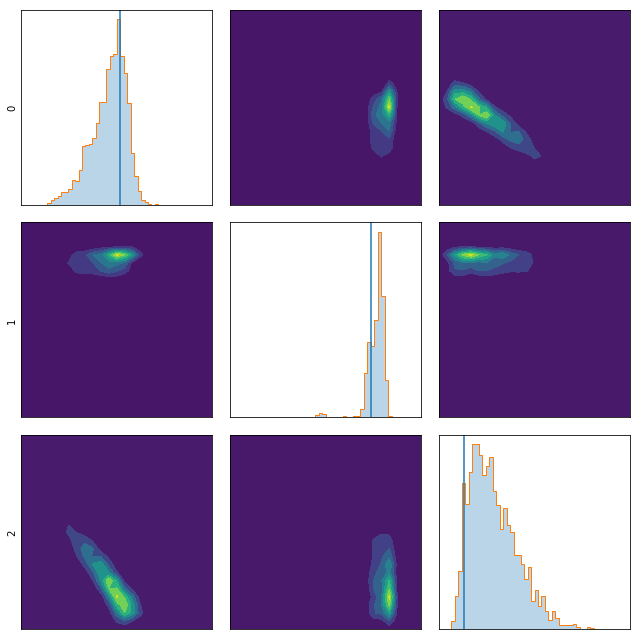

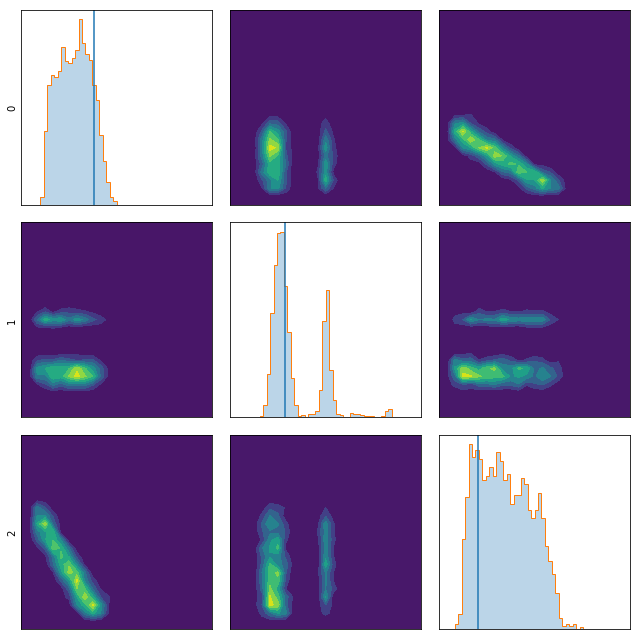

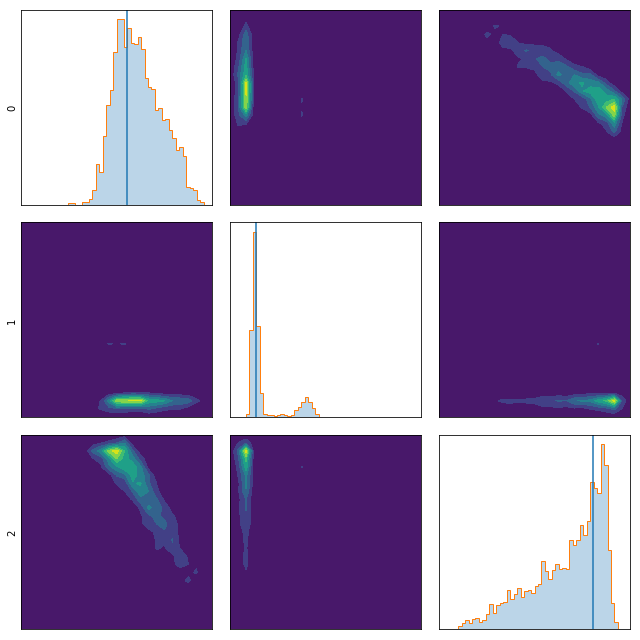

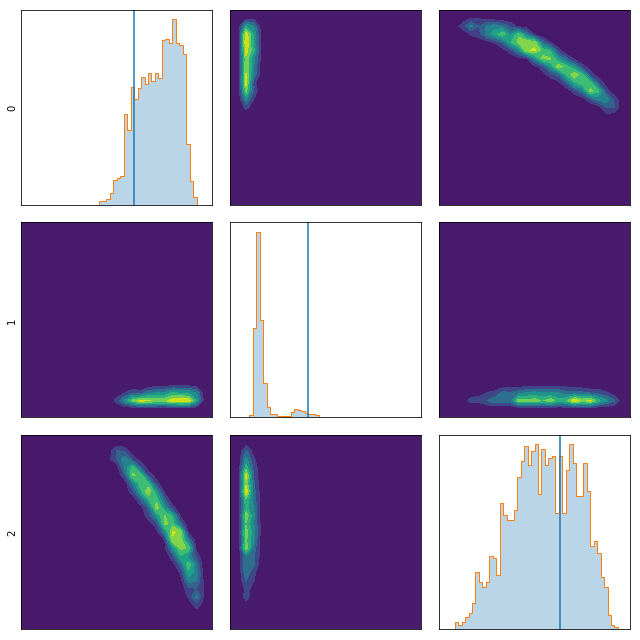

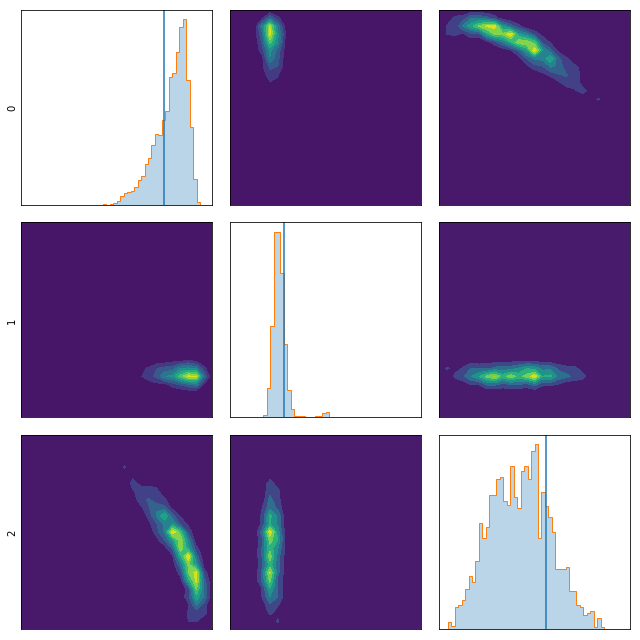

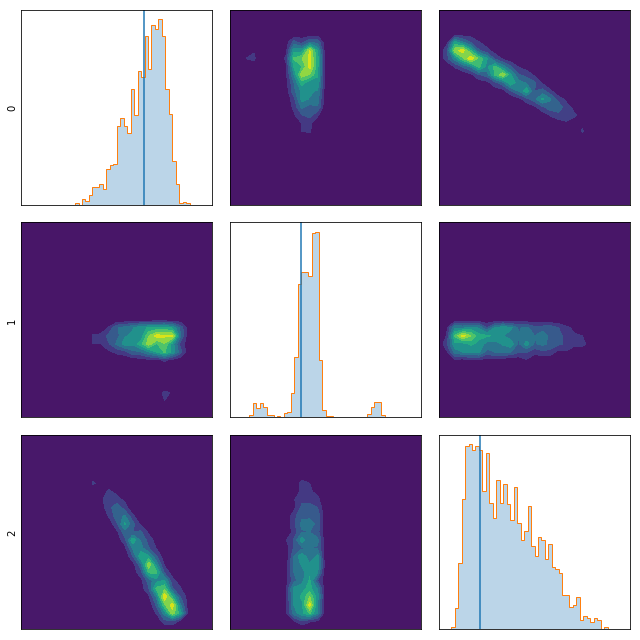

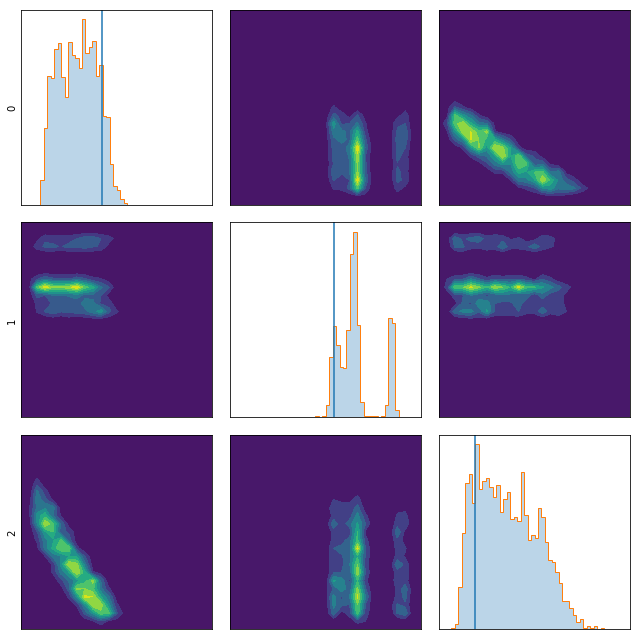

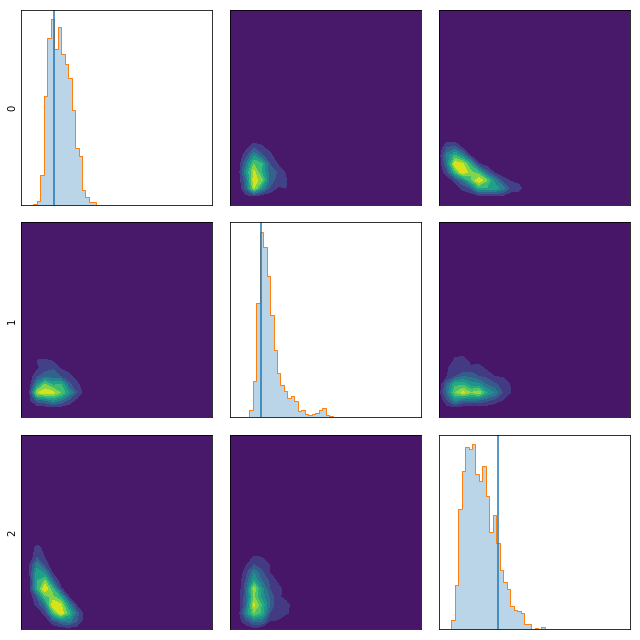

In [9]:
no_meas = [1,2,4,8]
no_runs = 5
dist_list = []
elbo_list = []
a_true = 0.005
b_true = 0.1

for q in range(len(no_meas)):
    print(q)
    mean = 0
    elbo_mean = 0
    for p in range(no_runs):
        torch.manual_seed(q*no_runs+p)
        x_true = torch.rand(no_meas[q], DIMENSION, device = device)*2-1
        meas = forward_model(x_true)+b_true*torch.randn_like(forward_model(x_true), device = device)*forward_model(x_true)+a_true*torch.randn_like(forward_model(x_true), device = device)
        model = create_INN(4,256)
        a = torch.ones(1,1, device = device).clone().detach()*0.2
        b = torch.ones(1,1, device = device).clone().detach()*0.2
        
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        for i in range(5000):
            l,a,b = train_inn_epoch(model, optimizer, a.detach(), b.detach(),forward_model)
        elbo = calc_elbo(a,b,model,meas)
        print(elbo)
        print(a,b)
        y_meas = torch.zeros(2000,ndim_y,device = device)
        y_meas = y_meas + meas[0]
        z = torch.randn(2000, DIMENSION, device = device)
        samples = model(z,c = y_meas)
        savePost(samples, DIMENSION, x_true[0], q*no_runs+p)
        ab_error = torch.abs((b-b_true))+ torch.abs((a-a_true))
        mean = mean + ab_error.cpu().data.numpy()
        elbo_mean += elbo
    dist_list.append(mean/no_runs)
    elbo_list.append(elbo_mean/no_runs)





[0.034057023529343686, 0.01491837838524902, 0.011316375260973618, 0.00817674421076042]
[tensor(78.3254, device='cuda:0'), tensor(78.5386, device='cuda:0'), tensor(79.6570, device='cuda:0'), tensor(79.7032, device='cuda:0')]
tensor(79.0561)


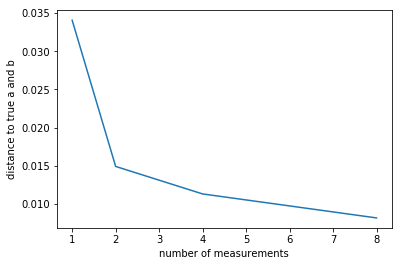

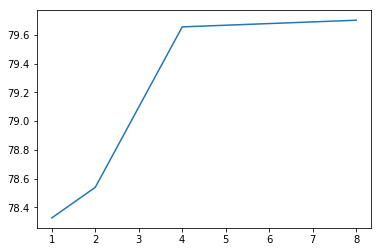

In [10]:
print(dist_list)
print(elbo_list)
print(torch.mean(torch.tensor(elbo_list)))
plt.plot(no_meas,dist_list)
plt.xlabel("number of measurements")
plt.ylabel("distance to true a and b")
plt.savefig('forward_error_plot')
plt.show()
plt.figure()
plt.plot(no_meas,elbo_list)
plt.show()
